In [1]:
import pandas as pd
import datetime
import re

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

In [3]:
df = pd.read_csv('data/archive/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Clean dataset

In [5]:
def map_label(val):
    if val == 0:
        return 'Negative'
    elif val == 2:
        return 'Neutral'
    else:
        return 'Positive'

def convert_date(val):
    val = val.replace('PDT ', '')
    return datetime.datetime.strptime(val , '%a %b %d %H:%M:%S %Y').strftime('%Y-%m-%d')

In [6]:
df['label'] = df['target'].apply(lambda x: map_label(x))

df['formatted_date'] = df['date'].apply(lambda x: convert_date(x))

In [7]:
# Lets clean up the text
def remove_tag(string):
    return re.sub('<.*?>','',string)

def remove_mention(text):
    return re.sub(r'@\w+','',text)

def remove_hash(text):
    return re.sub(r'#\w+','',text)

def remove_newline(string):
    return re.sub('\n', '', string)

def remove_url(string):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)

def remove_number(text):
    return re.sub(r'[0-9]+','',text)

def remove_punc(text):
    return re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)

def text_strip(string):
    return re.sub('\s{2,}', ' ', string.strip())

def remove_thi_amp_ha_words(string):
    return re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)

def clean_text(text):
    text = text.lower()
    text = remove_tag(text)
    text = remove_mention(text)
    text = remove_newline(text)
    text = remove_url(text)
    text = remove_number(text)
    text = remove_thi_amp_ha_words(text)
    text = text_strip(text)
    
    return text

In [8]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

# EDA

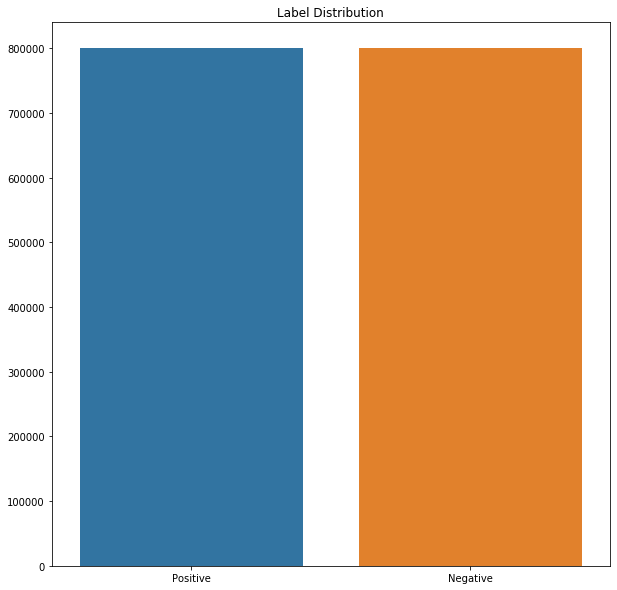

In [9]:
# Positive and negative distribution
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 10))
plt.title('Label Distribution')
rect = sns.barplot(label_counts.keys(), label_counts.values)

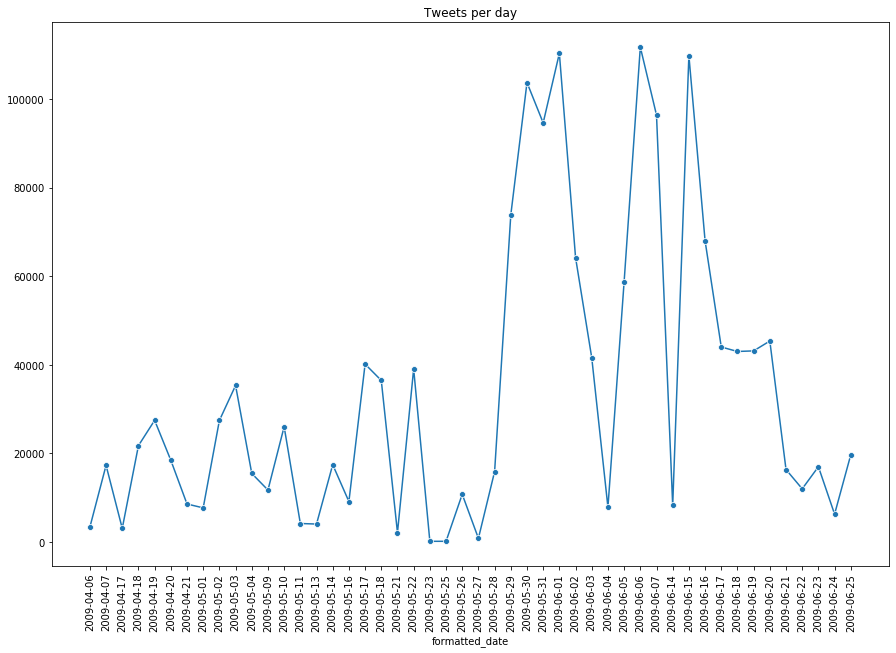

In [10]:
# Number of tweets according to days
date_count = df.groupby('formatted_date').count()['target']

plt.figure(figsize=(15, 10))

plt.xticks(rotation='vertical')
plt.title('Tweets per day')
sns.lineplot(
    date_count.keys(), date_count.values,  
    marker="o",
)

In [11]:
# Get top 10 users
top_users = df.groupby(['user']).count().sort_values('ids', ascending=False).iloc[:10]

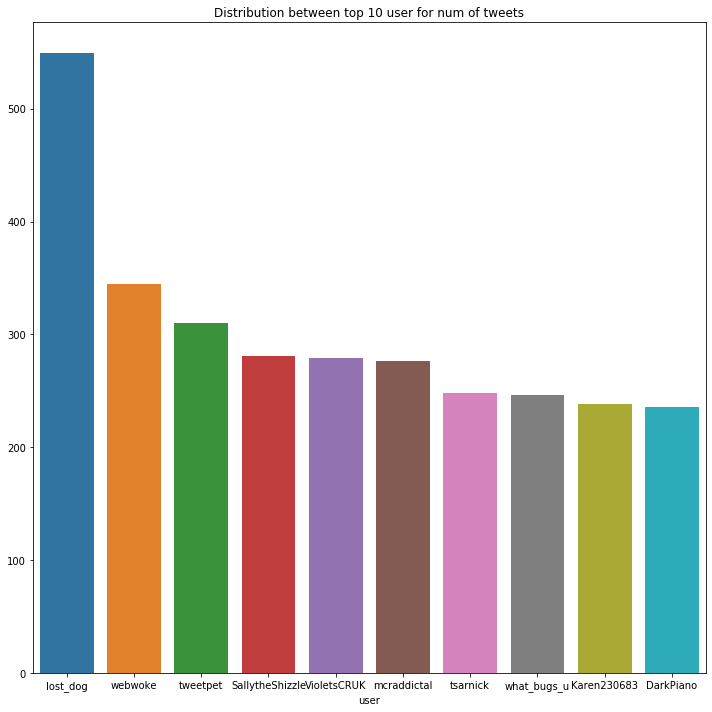

In [12]:
plt.figure(figsize=(10, 10))

plt.title('Distribution between top 10 user for num of tweets')
sns.barplot(
    top_users['target'].keys(), top_users['target'].values
)
plt.tight_layout()

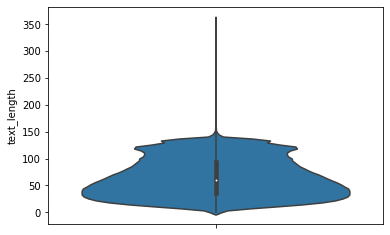

In [13]:
df['text_length'] = df['text'].apply(lambda x: len(x))
sns.violinplot(
    y='text_length', data=df,
    meanline_visible=True, fillcolor='royalblue', opacity=0.6,
    x0='Tweet Text Length'
)

In [16]:
# Use word cloud 
from wordcloud import WordCloud

In [17]:
used_words = WordCloud(
    width=600,height=400
).generate(" ".join(df['text']))

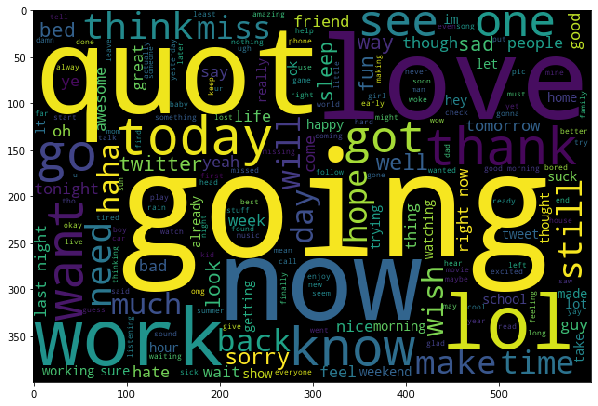

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(used_words)

In [19]:
# n gram frequency
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
def get_ngram(corpus, nrange, n=None):
    vec = CountVectorizer(stop_words='english', ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return pd.DataFrame(words_freq[:n])

In [21]:
for i in range(1, 4):
    ngram_frame = get_ngram(df['text'], (i, i), 10)
    print(ngram_frame)

          0      1
0      awww   5618
1    bummer   1558
2   shoulda    358
3       got  61436
4     david   2471
5      carr     80
6       day  89502
7     upset   2733
8    update   4361
9  facebook   4490
                  0   1
0       awww bummer   7
1    bummer shoulda   1
2       shoulda got  13
3         got david   7
4        david carr   1
5          carr day   1
6      upset update   1
7   update facebook  28
8  facebook texting   2
9    texting result   1
                         0  1
0      awww bummer shoulda  1
1       bummer shoulda got  1
2        shoulda got david  1
3           got david carr  1
4           david carr day  1
5    upset update facebook  1
6  update facebook texting  1
7  facebook texting result  1
8    texting result school  1
9      result school today  1


In [22]:
# Write to a new csv for easy of use later on
df.to_csv('data/filtered.csv', index=False)

In [23]:
pd.read_csv('data/filtered.csv')

,target,ids,date,flag,user,text,label,formatted_date,text_length
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got david...",Negative,2009-04-06,77
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...,Negative,2009-04-06,110
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball. managed to sa...,Negative,2009-04-06,76
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,2009-04-06,46
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"no, it's not behaving at all. i'm mad. why am ...",Negative,2009-04-06,93
...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up. having no school is the best fee...,Positive,2009-06-16,55
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb.com - very cool to hear old walt interv...,Positive,2009-06-16,61
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover? ask me f...,Positive,2009-06-16,56
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time!!! tu...,Positive,2009-06-16,62
